In [1]:
from Autoencoder import *
from make_video import *

import cv2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, InputLayer,Conv2D,MaxPool2D,UpSampling2D,Conv2DTranspose,Cropping2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0],
                                                                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=(1024*4))])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs
1 Physical GPUs, 1 Logical GPUs


## Parameters

In [2]:
DATASET = r'C:\Users\Saad.LAKES\Desktop\Autoencoders\Videos\Dataset' ## where there is dataset
DATASET_NAME = r'bunny_video.mp4' ## Name of the video
FRAMES = r'C:\Users\Saad.LAKES\Desktop\Autoencoders\Videos\Results\Video_Frames' ## where you want to save the frames
RECONSTRUCTED = r'C:\Users\Saad.LAKES\Desktop\Autoencoders\Videos\Results\ReconVideo_Frames' ## where the reconstructed frames are saved

WIDTH = 640 ## width of the reconstrcted image
HEIGHT = 480 ## height of the reconstrcted image
FPS = 25 ## fps of the reconstrcted image
SLICES = 2 ## Number of slices to be made on the image

EMBEDDING_SIZE = 512 ## bottleneck layer nodes

Loading Video...
Completed
The fps is 25.0, The width of the frame is 1280 and the height of the frame is 720
(1478, 480, 320, 3)


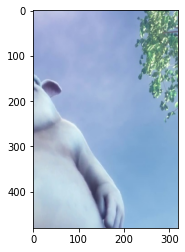

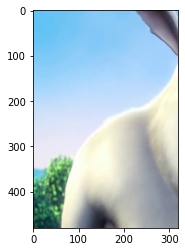

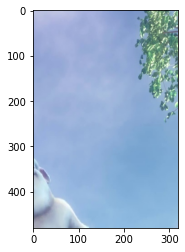

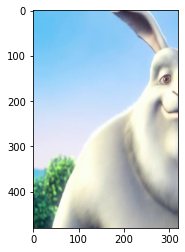

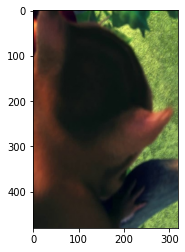

In [3]:
names,fps,width,height = read_video(FRAMES,os.path.join(DATASET,DATASET_NAME))

print(f'The fps is {fps}, The width of the frame is {width} and the height of the frame is {height}')

images1 = np.array(read_imgs(FRAMES,names,SLICES,WIDTH,HEIGHT))
print(images1.shape)
images = images1.astype('float32')/255.

## Sanity check on the images
ran = random.sample(range(0,len(images)),5)
for r in ran:
    plt.imshow(images[r])
    plt.show()

In [4]:
images.shape

(1478, 480, 320, 3)

In [5]:
train,test = splitter(images,0.1)
print(f'The shape of train is {train.shape}')
print(f'The shape of test is {test.shape}')

The shape of train is (1330, 480, 320, 3)
The shape of test is (148, 480, 320, 3)


In [6]:
## SSIM = 0.94
# The encoder
encoder = Sequential()
encoder.add(InputLayer((480,320,3)))
encoder.add(Conv2D(filters=32,kernel_size=3,strides=2,padding='same'))
encoder.add(Conv2D(filters=32,kernel_size=3,strides=2,padding='same'))
encoder.add(Conv2D(filters=32,kernel_size=3,strides=2,padding='same'))
encoder.add(Conv2D(filters=32,kernel_size=3,strides=2,padding='same'))

# The decoder
decoder = Sequential()
decoder.add(InputLayer((30,20,32)))
decoder.add(Conv2DTranspose(filters=32,kernel_size=3,strides=2,padding='same'))
decoder.add(Conv2DTranspose(filters=32,kernel_size=3,strides=2,padding='same'))
decoder.add(Conv2DTranspose(filters=32,kernel_size=3,strides=2,padding='same'))
decoder.add(Conv2DTranspose(filters=3,kernel_size=3,strides=2,padding='same'))

In [221]:
filterss = 16
# The encoder
encoder = Sequential()
encoder.add(InputLayer((480,320,3)))
encoder.add(Conv2D(filters=filterss,kernel_size=3,strides=2,padding='same'))
encoder.add(Conv2D(filters=filterss,kernel_size=3,strides=2,padding='same'))
encoder.add(Conv2D(filters=filterss,kernel_size=3,strides=2,padding='same'))
encoder.add(Conv2D(filters=filterss,kernel_size=3,strides=2,padding='same'))


# The decoder
decoder = Sequential()
decoder.add(InputLayer((30,20,filterss)))
decoder.add(Conv2DTranspose(filters=filterss,kernel_size=3,strides=2,padding='same'))
decoder.add(Conv2DTranspose(filters=filterss,kernel_size=3,strides=2,padding='same'))
decoder.add(Conv2DTranspose(filters=filterss,kernel_size=3,strides=2,padding='same'))
decoder.add(Conv2DTranspose(filters=3,kernel_size=3,strides=2,padding='same'))

In [7]:
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 240, 160, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 120, 80, 32)       9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 40, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 30, 20, 32)        9248      
Total params: 28,640
Trainable params: 28,640
Non-trainable params: 0
_________________________________________________________________


In [8]:
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose (Conv2DTran (None, 60, 40, 32)        9248      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 120, 80, 32)       9248      
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 240, 160, 32)      9248      
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 480, 320, 3)       867       
Total params: 28,611
Trainable params: 28,611
Non-trainable params: 0
_________________________________________________________________


In [9]:
inp = Input((480,320,3))
code = encoder(inp)
reconstruction = decoder(code)
model = Model(inp,reconstruction)
model.compile(optimizer='adam',loss='mse',metrics=['mae'])
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 480, 320, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 30, 20, 32)        28640     
_________________________________________________________________
sequential_1 (Sequential)    (None, 480, 320, 3)       28611     
Total params: 57,251
Trainable params: 57,251
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
240/240 [==============================] - 5s 21ms/step - loss: 0.0244 - mae: 0.0970 - val_loss: 0.0049 - val_mae: 0.0476
Epoch 2/50
240/240 [==============================] - 5s 20ms/step - loss: 0.0046 - mae: 0.0472 - val_loss: 0.0046 - val_mae: 0.0499
Epoch 3/50
240/240 [==============================] - 5s 20ms/step - loss: 0.0037 - mae: 0.0421 - val_loss: 0.0032 - val_mae: 0.0382
Epoch 4/50
240/240 [==============================] - 5s 20ms/step - loss: 0.0030 - mae: 0.0367 - val_loss: 0.0023 - val_mae: 0.0316
Epoch 5/50
240/240 [==============================] - 5s 20ms/step - loss: 0.0022 - mae: 0.0317 - val_loss: 0.0018 - val_mae: 0.0255
Epoch 6/50
240/240 [==============================] - 5s 20ms/step - loss: 0.0019 - mae: 0.0282 - val_loss: 0.0016 - val_mae: 0.0239
Epoch 7/50
240/240 [==============================] - 5s 19ms/step - loss: 0.0018 - mae: 0.0271 - val_loss: 0.0016 - val_mae: 0.0262
Epoch 8/50
240/240 [==============================] - 5s 19ms/step - 

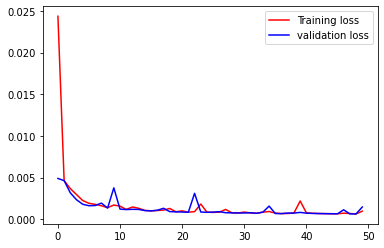

In [10]:
filepath = 'weights_32.hdf5'
checkpoint = ModelCheckpoint(filepath,monitor='val_loss',verbose=0,save_best_only=True,mode=min)

history=model.fit(train,train,epochs=50,batch_size=5,validation_split=0.1,callbacks=[checkpoint])

plt.plot(history.history['loss'],'r',label='Training loss')
plt.plot(history.history['val_loss'],'b',label='validation loss')
plt.legend()
plt.show()

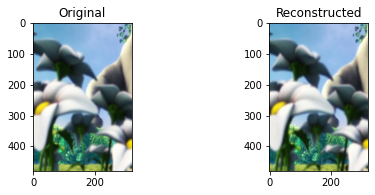

------------------------------ SSIM: 0.9606803720526246 ------------------------------


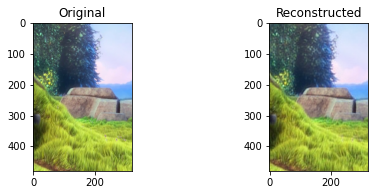

------------------------------ SSIM: 0.7863121437540253 ------------------------------


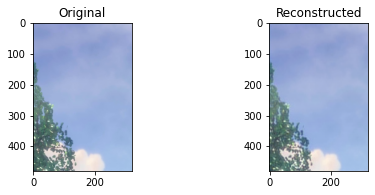

------------------------------ SSIM: 0.9881969436544132 ------------------------------


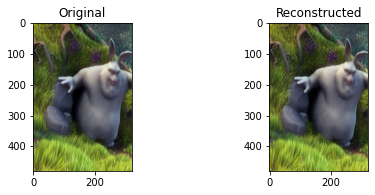

------------------------------ SSIM: 0.7318658686451331 ------------------------------


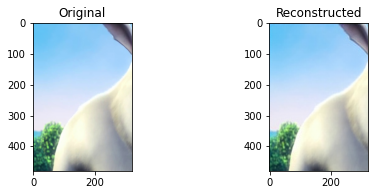

------------------------------ SSIM: 0.9518806657853767 ------------------------------


In [12]:
model.load_weights(filepath)

num_test = random.sample(range(0,len(test)),5)
for i in num_test:
    img = test[i]
    visualize(img,encoder,decoder)

In [11]:
bottle = encoder.predict(test)
predicted = decoder.predict(bottle)
overall_ssim(test,predicted)

0.9444784493111069

In [ ]:
import gc
pred = []
for i in range(len(images)):
    imgs_new = np.expand_dims(images[i],axis=0)
    code = encoder.predict(imgs_new)
    preds = decoder.predict(code)
    pred.append(preds)
    del(preds)
    del(code)
    del(imgs_new)
    gc.collect()
    
pred1=np.array(pred)
pred1=pred1.reshape(pred1.shape[0],pred1.shape[2],pred1.shape[3],pred1.shape[4])
pred2 = pred1 * 255.

In [251]:
p = r'C:\Users\Saad.LAKES\Desktop\Autoencoders\Videos\Results\ReconVideo_Frames'
p = p.replace('\\','/')

In [252]:
p1=os.getcwd()
os.chdir(p)
os.getcwd()

'C:\\Users\\Saad.LAKES\\Desktop\\Autoencoders\\Videos\\Results\\ReconVideo_Frames'

In [259]:
names1=[]
images1=[]
for i in range(len(pred2)):
    cv2.imwrite('frame_{}.jpg'.format(i),pred2[i])
    
for i in range(len(pred2)):
    ims = cv2.imread('frame_{}.jpg'.format(i))
    name = 'frame_{}.jpg'.format(i)
    names1.append(name)
    images1.append(ims)

In [269]:
video = cv2.VideoWriter('recon.avi', 0 , 25.0, (320,480))
for image in names1:
    video.write(cv2.imread(image))
cv2.destroyAllWindows()
video.release()

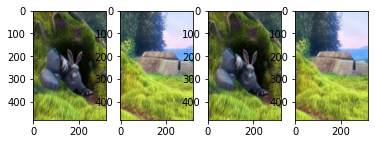

In [273]:
x1 = cv2.imread(names1[0])
x2 = cv2.imread(names1[1])
x3 = cv2.imread(names1[2])
x4 = cv2.imread(names1[3])

plt.subplot(141)
plt.imshow(x1)

plt.subplot(142)
plt.imshow(x2)

plt.subplot(143)
plt.imshow(x3)

plt.subplot(144)
plt.imshow(x4)

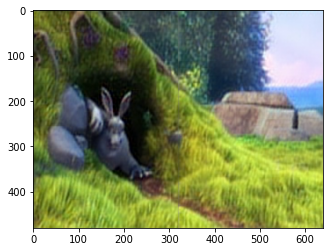

In [274]:
x_1 = cv2.hconcat([x1,x2])
plt.imshow(x_1)

In [276]:
os.getcwd()

'C:\\Users\\Saad.LAKES\\Desktop\\Autoencoders\\Videos\\Results\\ReconVideo_Frames'

In [280]:
count=0
for i in range(0,len(images1)-1,2):
    x1 = cv2.imread(names1[i])
    x2 = cv2.imread(names1[i+1])
    x3 = cv2.hconcat([x1,x2])
    try:
        os.remove(names1[i])
        os.remove(names1[i+1])
    except IndexError:
        print(i)
        break
    cv2.imwrite('frame_{}.jpg'.format(count),x3)
    count+=1

In [281]:
video = cv2.VideoWriter('recon.avi', 0 , 25.0, (640,480))
for image in names1:
    video.write(cv2.imread(image))
cv2.destroyAllWindows()
video.release()

In [282]:
os.chdir('C:/Users/Saad.LAKES/Desktop/Autoencoders/Videos/Results/Video_Frames')

In [283]:
video1 = cv2.VideoWriter('original.avi', 0 , 25.0, (640,480))
for image in names:
    video1.write(cv2.imread(image))
cv2.destroyAllWindows()
video1.release()

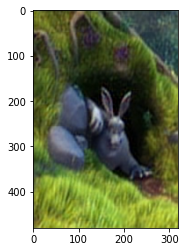

In [284]:
plt.imshow(images1[0])

540 960 3
480
540 960 3
480


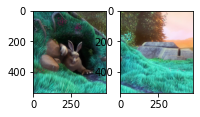

In [47]:
plt.subplot(141)
plt.imshow(imCrop(images[1],2)[0])
plt.subplot(142)
plt.imshow(imCrop(images[1],2)[1])
# plt.subplot(143)
# plt.imshow(imCrop(images[1],4)[2])
# plt.subplot(144)
# plt.imshow(imCrop(images[1],4)[3])

In [33]:
images[1].shape

(540, 960, 3)

In [35]:
images[1][540,480]

IndexError: index 540 is out of bounds for axis 0 with size 540

In [4]:
x=image_slicer.slice('frame_1.jpg',16,save=False)

In [57]:
from PIL import ImageDraw, ImageFont

In [58]:
for tile in x:
    overlay = ImageDraw.Draw(tile.image)

In [59]:
overlay

In [5]:
np.asarray(x[1].image)

array([[[ 35,  45,  36],
        [ 31,  43,  31],
        [ 36,  48,  36],
        ...,
        [ 68,  89, 110],
        [ 62,  77, 100],
        [ 65,  73,  96]],

       [[ 38,  48,  39],
        [ 35,  47,  35],
        [ 40,  52,  40],
        ...,
        [ 70,  93, 109],
        [ 62,  79,  95],
        [ 63,  74,  92]],

       [[ 43,  55,  45],
        [ 43,  57,  44],
        [ 46,  60,  47],
        ...,
        [ 67,  95,  99],
        [ 58,  81,  87],
        [ 56,  75,  82]],

       ...,

       [[ 66,  77,  45],
        [ 61,  72,  38],
        [ 61,  72,  38],
        ...,
        [ 30,  58,  59],
        [ 30,  58,  61],
        [ 30,  58,  61]],

       [[ 59,  70,  38],
        [ 51,  62,  28],
        [ 48,  59,  25],
        ...,
        [ 30,  58,  59],
        [ 29,  57,  60],
        [ 28,  56,  59]],

       [[ 48,  59,  27],
        [ 40,  51,  17],
        [ 38,  49,  15],
        ...,
        [ 29,  57,  58],
        [ 28,  56,  59],
        [ 27,  55,  58]]